# Building a CNN on Fashion MNIST

This notebook demonstrates how a data scientist would approach exploring a dataset, building a model, and saving that model within a workflow utilizing [Quilt T4](https://quiltdocs.gitbook.io/t4/).

We will build a convolutional neural network based on the [Fashion MNIST](https://www.kaggle.com/zalando-research/fashionmnist) dataset. Fashion MNIST is an image dataset curated by the folks at Zalando Research specifically for the purpose of providing a good default dataset for use in image classification tasks. It consists of a moderately large set of 28x28 images of various fashion items, which have been assigned to one of ten different classes. This dataset is useful for benchmarking image classification challenges, as it is significantly harder than the extremely well-known MNIST dataset, whilst still being easy enough that relatively straightforward image classification techniques may be used to solve it. Classification of clothing (for the purposes of recommendation) is a very well-traveled problem in startups these days, and this well-curated dataset is a great introduction to this problem.

We'll cover the full workflow typical for a data scientist: exploration, model training, model evaluation, and then saving that model.


## Installing dependencies

The full list of dependencies required to run this notebook is available in the `requirements.txt` file bundled with this code repository. To run this notebook successfully you should first install these: `pip install -r requirements.txt`.

## Getting the data

The first step to building a model is actually getting the data. We will use [Quilt T4](https://github.com/quiltdata/t4) to do this.

Depending on when you are reading this, an instance of Quilt T4 that you can publicly download from may or may not be ready yet. If it is, great! Run the following code cell and you will be good to go.

If it isn't, you can also get the data directly from [its source repository](https://github.com/zalandoresearch/fashion-mnist) on GitHub.

In [9]:
# import t4
# t4.Package.install("quilt/fashion_mnist", registry="s3://krunal-bdso-sagemaker", dest=".")
# !mv "quilt/fashion_mnist/fashion-mnist_train.csv" "fashion-mnist_train.csv"
# !rm -rf "quilt/"

import boto3
import botocore

BUCKET_NAME = 'krunal-bdso-sagemaker' # replace with your bucket name
KEY = 'quilt/fashion_mnist/fashion-mnist_train.csv' # replace with your object key

s3 = boto3.resource('s3')

try:
    s3.Bucket(BUCKET_NAME).download_file(KEY, 'fashion-mnist_train.csv')
except botocore.exceptions.ClientError as e:
    if e.response['Error']['Code'] == "404":
        print("The object does not exist.")
    else:
        raise

In [1]:
import numpy as np
import pandas as pd

data_train = pd.read_csv('fashion-mnist_train.csv')
data_train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Exploring the data

There are 10 unique classes in the dataset.

In [2]:
sorted(data_train.label.unique())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

If we plot these out we can see what they are.

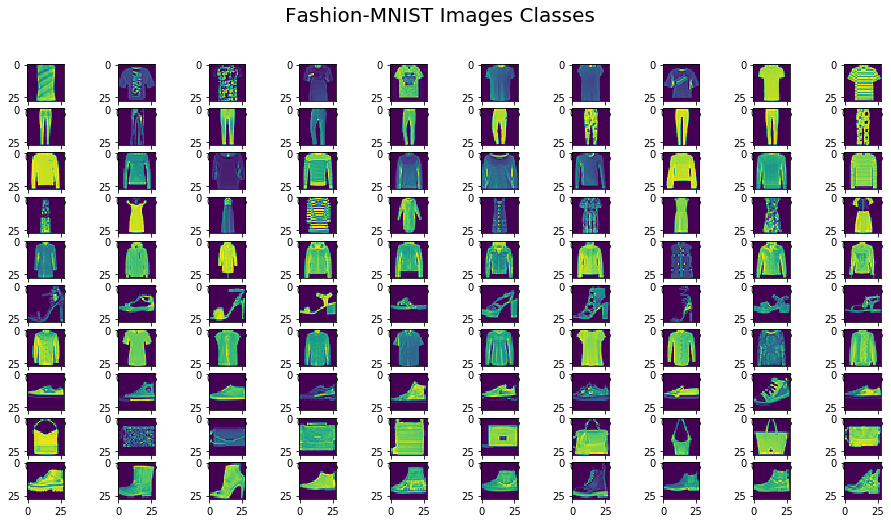

In [3]:
%matplotlib inline

labels = sorted(data_train.label.unique())
n_samples = 10

import matplotlib.pyplot as plt
fig, axarr = plt.subplots(len(labels), n_samples, figsize=(16, 8))

for j, label in enumerate(labels):
    for k, img_arr in enumerate(data_train.query("label == @label").sample(n_samples, random_state=42)\
                                    .values[:, 1:].reshape((n_samples, 28, 28))):
        axarr[j][k].imshow(img_arr)

fig.suptitle("Fashion-MNIST Images Classes", fontsize=20)
pass

We can back this out into explicit class names:

In [4]:
img_class_key = {
    0: 't-shirt',
    1: 'pants',
    2: 'pullover',
    3: 'dress',
    4: 'coat',
    5: 'sandal',
    6: 'shirt',
    7: 'sneakers',
    8: 'handbag',
    9: 'boot'
}

This dataset is completely balanced: every class appears in the dataset the same number of times, exactly 6000. This is great because it prevents using from running into any problems with having to perform [imbalanced learning](https://towardsdatascience.com/dealing-with-imbalanced-classes-in-machine-learning-d43d6fa19d2).

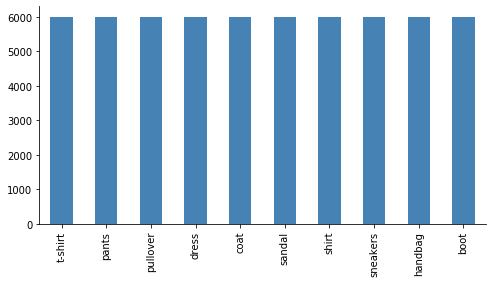

In [5]:
import seaborn as sns
label_counts = data_train['label'].value_counts()
label_counts.index = img_class_key.values()
label_counts.plot.bar(color='steelblue', figsize=(8, 4))
sns.despine()
pass

## Training a model

For the purposes of demonstration, let's train a CNN model on this dataset. CNNs provide the current bleeding edge of performance on these kinds of image classification problems. If you are unfamiliar with CNNs, [this blog post](https://ujjwalkarn.me/2016/08/11/intuitive-explanation-convnets/) provides a good conceptual overview.

In [6]:
# exclude the class label from the training data, otherwise we have nothing to train on
X = data_train.iloc[:, 1:].values

# one-hot encode the classes
y = pd.get_dummies(data_train.iloc[:, 0].values).values

# partition the dataset into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape the flat [0, 255]-entry list into a [0, 1]-entry grid, as desired by the CNN.
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float') / 255
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float') / 255

In [7]:
# import keras
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization

clf = Sequential()
clf.add(Conv2D(32, kernel_size=(3, 3),
               activation='relu',
               kernel_initializer='he_normal',
               input_shape=(28, 28, 1)))
clf.add(MaxPooling2D((2, 2)))
clf.add(Dropout(0.25))
clf.add(Conv2D(64, (3, 3), activation='relu'))
clf.add(MaxPooling2D(pool_size=(2, 2)))
clf.add(Dropout(0.25))
clf.add(Conv2D(128, (3, 3), activation='relu'))
clf.add(Dropout(0.4))
clf.add(Flatten())
clf.add(Dense(128, activation='relu'))
clf.add(Dropout(0.3))
clf.add(Dense(10, activation='softmax'))

clf.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.Adam(),
            metrics=['accuracy'])

Using TensorFlow backend.
/Users/BCMC-KPURI/Projects/BDSO-USCIS/aws-sagemaker/quilt-sagemaker-demo/.venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/BCMC-KPURI/Projects/BDSO-USCIS/aws-sagemaker/quilt-sagemaker-demo/.venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/BCMC-KPURI/Projects/BDSO-USCIS/aws-sagemaker/quilt-sagemaker-demo/.venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version o






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



/Users/BCMC-KPURI/Projects/BDSO-USCIS/aws-sagemaker/quilt-sagemaker-demo/.venv/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/BCMC-KPURI/Projects/BDSO-USCIS/aws-sagemaker/quilt-sagemaker-demo/.venv/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/BCMC-KPURI/Projects/BDSO-USCIS/aws-sagemaker/quilt-sagemaker-demo/.venv/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of num

**Important note**

For educational purposes we have set the number of epochs in the following code cell to just 1.

This will fail to generate a robust machine learning model but will make training take almost no time at all, which makes standing up this model yourself much easier.

To reproduce the robust outcomes in the evaluation section of this notebook set `epochs` to 30.

In [8]:
%%time

history = clf.fit(X_train, y_train, batch_size=512, epochs=1, verbose=1, validation_data=(X_test, y_test))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 48000 samples, validate on 12000 samples
Epoch 1/1
48000/48000 [==============================] - 22s 460us/step - loss: 1.0287 - acc: 0.6155 - val_loss: 0.5929 - val_acc: 0.7832
CPU times: user 52.8 s, sys: 13.7 s, total: 1min 6s
Wall time: 22.6 s


## Evaluating model performance

To evaluate model performance, let's start by looking at the training accuracy over training epochs. If we did a good job training our model the training and validation accuracy and loss will both be similar monotonic curves.

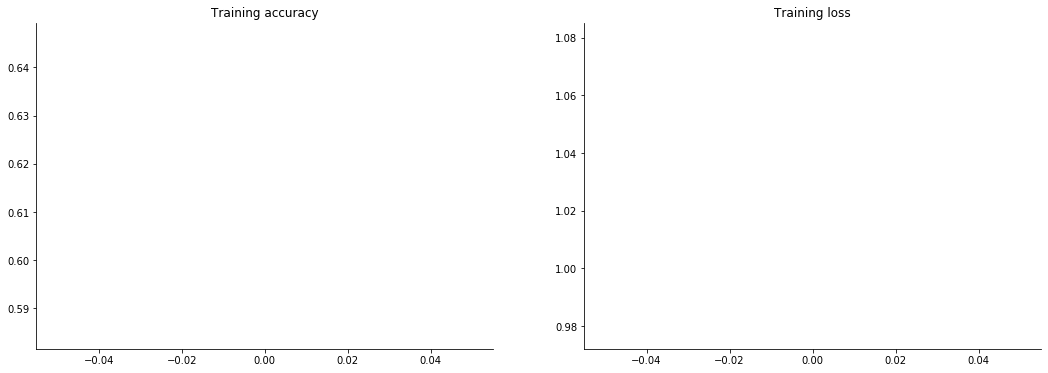

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

accuracy = history.history['acc']
loss = history.history['loss']
epochs = range(len(accuracy))

fig, axarr = plt.subplots(1, 2, figsize=(18, 6))
axarr[0].plot(epochs, accuracy)
axarr[0].set_title('Training accuracy')
sns.despine()

axarr[1].plot(epochs, loss)
axarr[1].set_title('Training loss')
sns.despine()

plt.show()

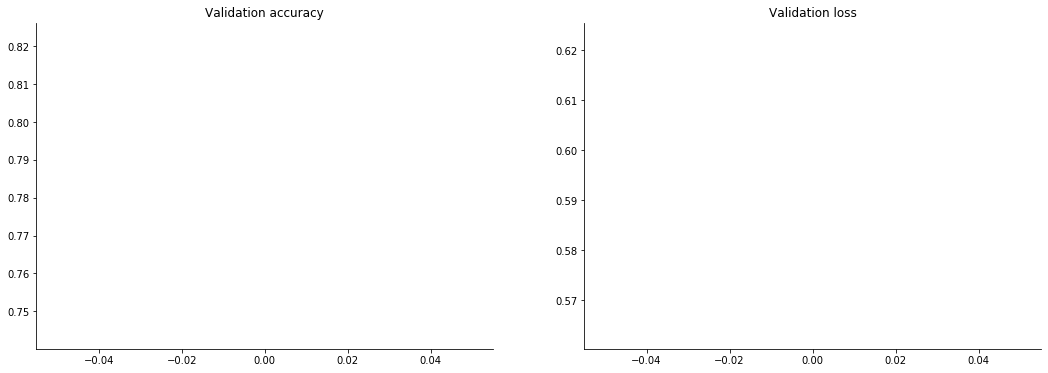

In [11]:
val_accuracy = history.history['val_acc']
val_loss = history.history['val_loss']
epochs = range(len(val_accuracy))

fig, axarr = plt.subplots(1, 2, figsize=(18, 6))
axarr[0].plot(epochs, val_accuracy)
axarr[0].set_title('Validation accuracy')
sns.despine()

axarr[1].plot(epochs, val_loss)
axarr[1].set_title('Validation loss')
sns.despine()

plt.show()

Looks good. Let's see what classes the classifier performed well on and which ones it struggled with.

In [14]:
y_test_pred = clf.predict_classes(X_test)
y_test_classed = np.nonzero(y_test)[1]

In [15]:
from sklearn.metrics import classification_report
print(classification_report(y_test_pred, y_test_classed, target_names=img_class_key.values()))

              precision    recall  f1-score   support

     t-shirt       0.84      0.72      0.78      1422
       pants       0.95      0.97      0.96      1152
    pullover       0.73      0.54      0.62      1629
       dress       0.88      0.76      0.82      1429
        coat       0.68      0.61      0.64      1327
      sandal       0.93      0.91      0.92      1169
       shirt       0.12      0.42      0.19       356
    sneakers       0.89      0.89      0.89      1228
     handbag       0.93      0.96      0.94      1105
        boot       0.91      0.94      0.93      1183

    accuracy                           0.78     12000
   macro avg       0.79      0.77      0.77     12000
weighted avg       0.83      0.78      0.80     12000



We see here that certain classes are noticeably more distinguishable than others. We scored allmost all pants, sandals, and handbags correctly, indicating that these classes are highly separable. We fared worst on upper body clothing items: pullovers, coats, and especially shirts. None of this is very surprising; the silhouettes of shoes are very easy to tell apart from those of shirts, but amongst the different classes of shirts there's a lot of potential overlap.

Finally to evaluate our model complexity we can inspect which areas of the images the CNN is firing on. The following code snippet courtesy of François Chollet, the original author of Keras, who provides it in his "Deep Learning with Python" book.

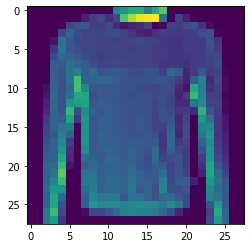

In [16]:
test_im = X_train[154]
plt.imshow(test_im.reshape(28,28), cmap='viridis', interpolation='none')
plt.show()

/Users/BCMC-KPURI/Projects/BDSO-USCIS/aws-sagemaker/quilt-sagemaker-demo/.venv/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("co..., outputs=[<tf.Tenso...)`
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/BCMC-KPURI/Projects/BDSO-USCIS/aws-sagemaker/quilt-sagemaker-demo/.venv/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


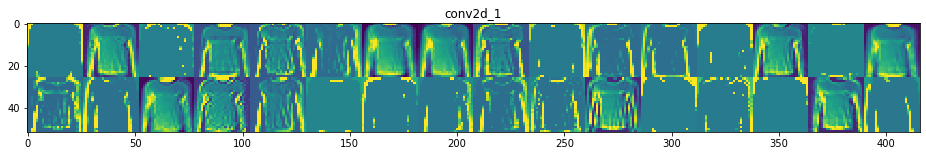

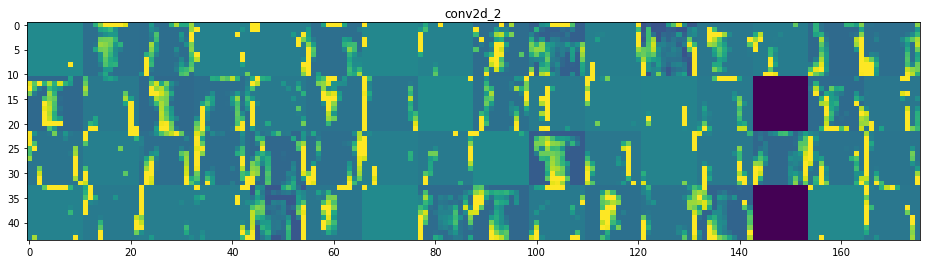

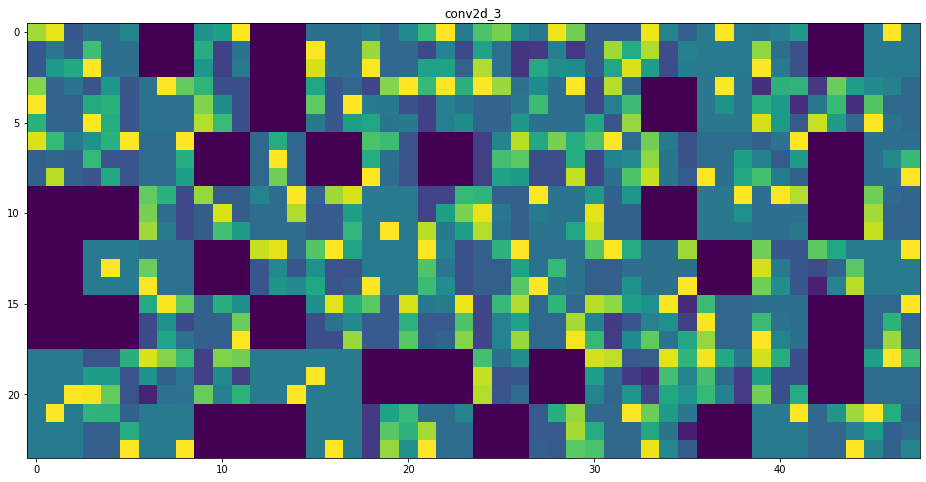

In [17]:
from keras import models
layer_outputs = [layer.output for layer in clf.layers[:8]]
activation_model = models.Model(input=clf.input, output=layer_outputs)
activations = activation_model.predict(test_im.reshape(1,28,28,1))

layer_names = []
for layer in clf.layers[:-1]:
    layer_names.append(layer.name) 
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    if layer_name.startswith('conv'):
        n_features = layer_activation.shape[-1]
        size = layer_activation.shape[1]
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))
        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,:, :, col * images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size,
                             row * size : (row + 1) * size] = channel_image
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

A CNN works by aggregating the features of an image into progressively higher feature pools, so the earlier layers in this visualization are easier to interpret than the later ones. We see that the first layer seems to fire mostly on edges of the image, and on the distinction between foreground and background in the image. The second layer seems to begin to focus on patterns on the article of clothing itself. The third layer is difficult to interpret.

Note that some images are completely blacked out, indicating neurons that did not fire at all. This is because those neurons were deadened by the regularization properties of the ReLU activation layers we are using in this CNN. A significant but not overwhelming percentage of the neurons in our third convolutional layer never fire, indicating relatively good fit of our model architecture to this data: too simple and no neurons will be regulated out; too complex and many more will be.

## Saving the model artifact

With our CNN in hand we finish by saving the model artifact. Note that you need to have access to the `s3://quilt-example` S3 bucket for the following code cell to work; if you do not have access to that bucket you should replace it in the path below with one you do have access to. `keras` models have a `save` command that we can run to persist a model to disk as an HDF5 file.

In [18]:
clf.save('clf.h5')

The SageMaker API expects model artifacts to be written to `/opt/ml/model`. It will zip that directory up into a `*.tar.gz` file and serialize that to an S3 filepath of your choice.

So to make this model-building notebook compatible wih SageMaker, we may do one of two things:

* Use `tar` to generate an archive file from the raw HDF5, and send that to S3. Then, every time we want to launch this model in AWS SageMaker, we will will have to first overwrite the estimator `model_path` like so:

    ```ipython
    sage.estimator.Estimator.model_data =\
    "s3://alpha-quilt-storage/aleksey/fashion_mnist_clf/clf.tar.gz"
    ```

* The alternative would be to save the raw `clf.h5` to a human-readable data package, and then additionally save the file to `/opts/ml/clf.h5` and letting Amazon archive and upload that to S3 for us. This doesn't require futzing with the `Estimator` class later on when we are trying to use the model.

I ultimately opted for the former option. Since the classifier is small, we can just create a single data package with both the raw `clf.h5` file and the SageMaker-compatible `clf.tar.gz` file; but for larger classifiers it'd be more elegant to keep them in separate packages.

In [9]:
# (t4.Package()
#      .set("clf.h5", "clf.h5")
#      .set("clf.tar.gz", "clf.tar.gz")
#      .push("quilt/quilt_sagemaker_demo", "s3://quilt-example", registry="s3://quilt-example")
# )

Push the model to `/opt/ml/model` so that SageMaker sees it.

**User Note**: Do not run the following line of code locally! This will create a file in the `/opt/` folder in your home directory which you don't want. This line is only here for use in a SageMaker-compatible Docker image.

In [ ]:
!tar -czvf clf.tar.gz clf.h5
!cp clf.tar.gz /opt/ml/model/clf.tar.gz